<a href="https://colab.research.google.com/github/PatriciaSojcakova/Zneus_Project2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Project_2/Project_2.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Project_2/Project_2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 2608759 bytes to /content/drive/MyDrive/Colab Notebooks/Project_2/Project_2.html


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
from PIL import Image
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from types import SimpleNamespace as Namespace

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_2/archive/sports.csv')

base_path = "/content/drive/MyDrive/Colab Notebooks/Project_2/archive/"
data['filepaths'] = base_path + data['filepaths']

#**1. Prieskumná analýza dát**

In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


###**1.1 Deskriptívne štatistiky**

Počet obrázkov

In [ ]:
print("Total images:", len(data))

Total images: 14493


Počet tried

In [ ]:
print("Number of classes:", data['labels'].nunique())

Number of classes: 100


Distribúcia obrázkov v triedach

In [ ]:
pd.set_option('display.max_rows', None)
display(data['labels'].value_counts())

,count
labels,
football,201
formula 1 racing,200
nascar racing,199
baseball,184
hockey,182
basketball,179
olympic wrestling,177
rugby,176
canoe slamon,174


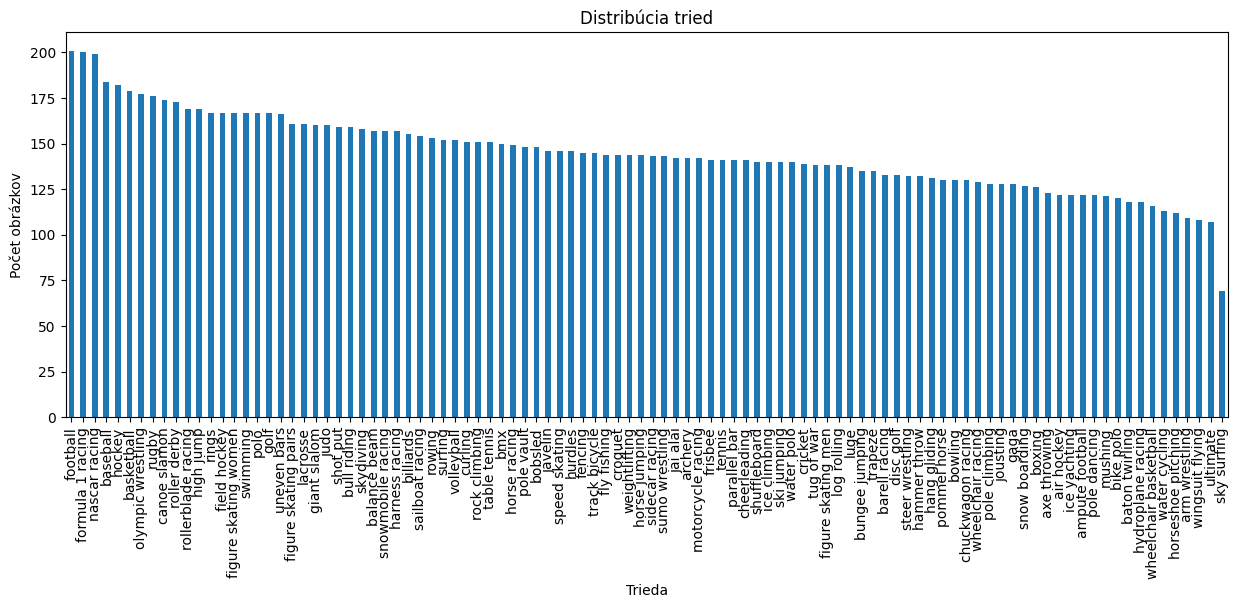

In [ ]:
plt.figure(figsize=(15,5))
data['labels'].value_counts().plot(kind='bar')
plt.title("Distribúcia tried")
plt.xlabel("Trieda")
plt.ylabel("Počet obrázkov")
plt.show()

###**1.2 Výber tried**

Vybrali sme 10 tried na klasifikáciu.

In [ ]:
selected_labels = [
    'football',
    'formula 1 racing',
    'basketball',
    'olympic wrestling',
    'hockey',
    'rugby',
    'canoe slamon',
    'rollerblade racing',
    'swimming',
    'rings',
]

data_filtered = data[data['labels'].isin(selected_labels)]

print(f"Original dataset shape: {data.shape}")
print(f"Filtered dataset shape: {data_filtered.shape}")

data = data_filtered.copy()


Original dataset shape: (14493, 4)
Filtered dataset shape: (1792, 4)


Nová distribúcia tried po filtrácii

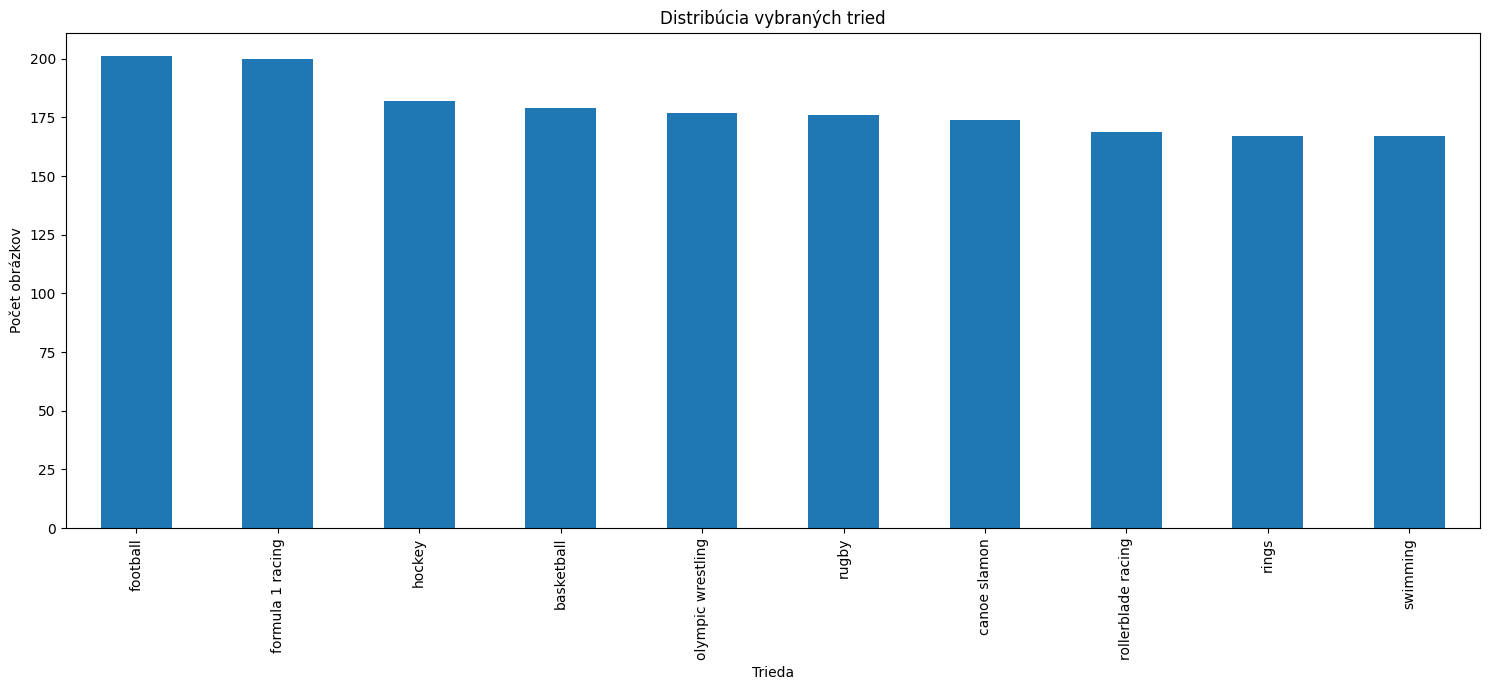

In [ ]:
plt.figure(figsize=(15, 7))
data['labels'].value_counts().plot(kind='bar')
plt.title("Distribúcia vybraných tried")
plt.xlabel("Trieda")
plt.ylabel("Počet obrázkov")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

###**1.3 Vizualizácia náhodných obrázkov**

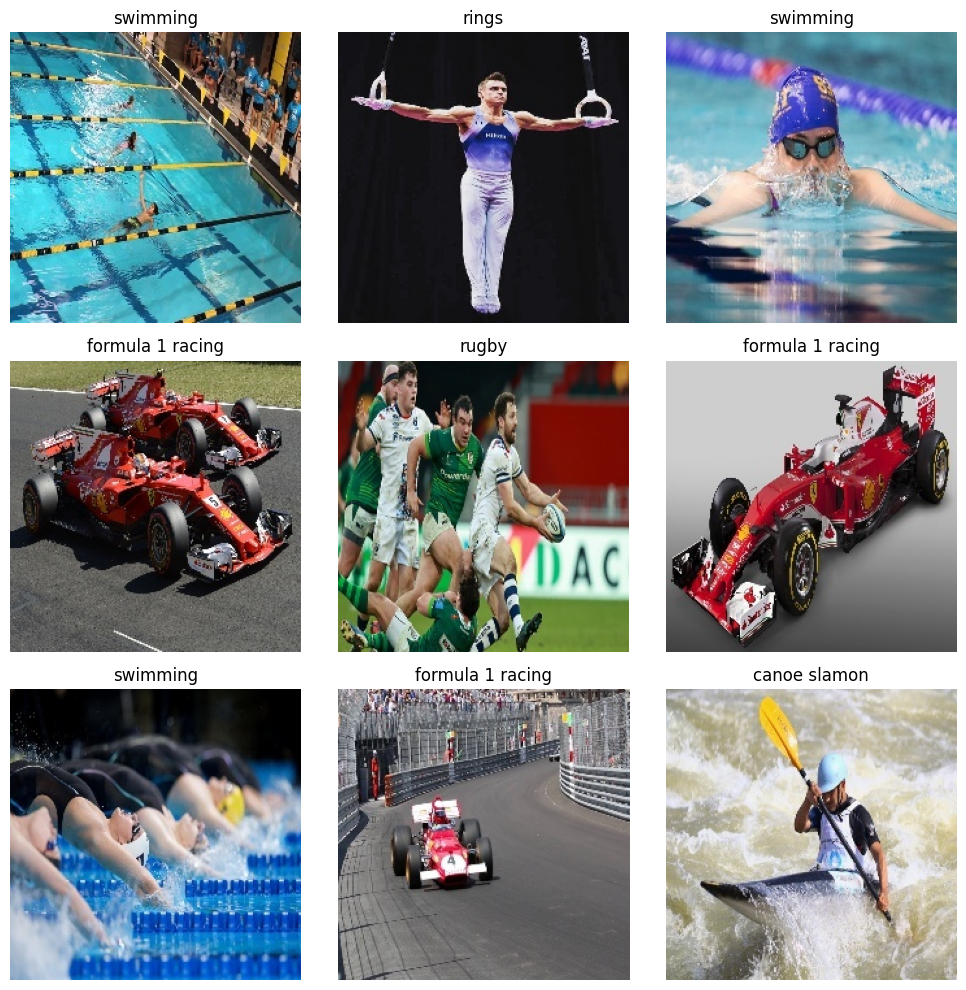

In [ ]:
import random

sample = data.sample(9)

plt.figure(figsize=(10,10))
for i, row in enumerate(sample.itertuples(), 1):
    img = Image.open(row.filepaths)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(row.labels)
    plt.axis('off')
plt.tight_layout()
plt.show()

###**1.4 Kontrola duplikátov**

Skontrolovali sme duplikáty z hľadiska riadkov a ciest ku konkrétnym obrázkom. Dataset neobsahuje duplikáty.

In [ ]:
print("Duplicated rows:", data.duplicated().sum())

Duplicated rows: 0


In [ ]:
print("Duplicated filepaths:", data['filepaths'].duplicated().sum())

Duplicated filepaths: 0


###**1.5 Outliery**

Skontrolovali sme rozmery náhodnej vzorky obrázkov, pričom sme zistili, že rozmery obrázkov sú rovnaké, teda nemusíme riešiť outliery.

In [ ]:
sample = data.sample(100, random_state=42)

widths = []
heights = []

for path in tqdm(sample['filepaths'], desc="Analyzing sample image sizes"):
    try:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        widths.append(np.nan)
        heights.append(np.nan)

sample['width'] = widths
sample['height'] = heights

Analyzing sample image sizes: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [ ]:
sample[['width', 'height']].describe()

,width,height
count,100.0,100.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


###**1.6 Kontrola poškodených obrázkov**

V náhodnej vzorke sme skontrolovali či sa v datasete môžu nachádzať poškodené obrázky. Výstupom je 0 chybných obrázkov.

In [ ]:
sample = data.sample(400, random_state=42)

corrupted = []

for path in tqdm(sample['filepaths'], desc="Checking corrupted images (sample)"):
    try:
        Image.open(path).verify()
    except:
        corrupted.append(path)

print("\nPoškodené obrázky vo vzorke:", len(corrupted))

Checking corrupted images (sample): 100%|██████████| 400/400 [03:39<00:00,  1.82it/s]


Poškodené obrázky vo vzorke: 0


In [ ]:
print("Počet vybraných obrázkov je", len(data))

Počet vybraných obrázkov je 1792


#**2. Preprocessing**

Na trénovacej množine sme použili tieto transformácie:

- náhodné vyrezanie časti obrázka a ponechanie rozmeru 128x128
- náhodné horizontálne otočenie
- náhodná rotácia do ±15°
- jemná zmena jasu a kontrastu
- jemné rozmazanie
- premenenie na tensor
- štandardizovanie obrazových kanálov

Na validačnej množine sme použili tieto trnsformácie:

- veľkosť 128x128
- premenenie na tensor
- štandardizovanie obrazových kanálov

Na testovaciu množinu sa nepoužívajú žiadne transformácie.
Cieľom augmentácií je zvýšiť variabilitu datasetu a znížiť overfitting.

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#**3. Predikčný model**

In [ ]:
class SportsDataset(Dataset):
    def __init__(self, df, transform=None, class_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepaths']
        label_name = row['labels']
        label = self.class_to_idx[label_name]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
class ImageDataModule:
    def __init__(self, data, batch_size, num_workers, train_transforms, valid_transforms):
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    def setup(self):

        train_df = self.data[self.data['data set'] == 'train']
        valid_df = self.data[self.data['data set'] == 'valid']
        test_df  = self.data[self.data['data set'] == 'test']

        print("Train rows:", len(train_df))
        print("Valid rows:", len(valid_df))
        print("Test rows:", len(test_df))

        # mapovanie label -> index
        class_names = sorted(self.data['labels'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        self.num_classes = len(class_names)
        print("Classes:", class_names)
        print("num_classes:", self.num_classes)


        self.train_dataset = SportsDataset(train_df, transform=self.train_transforms,
                                           class_to_idx=self.class_to_idx,)
        self.val_dataset   = SportsDataset(valid_df, transform=self.valid_transforms,
                                           class_to_idx=self.class_to_idx)
        self.test_dataset  = SportsDataset(test_df,  transform=self.valid_transforms,
                                           class_to_idx=self.class_to_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
class betterCNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
import matplotlib.pyplot as plt

class ImageTrainer:
    def __init__(self, model, data_module, cfg, device=None):
        self.model = model
        self.data_module = data_module
        self.cfg = cfg

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.train_loader = data_module.train_dataloader()
        self.val_loader   = data_module.val_dataloader()
        self.test_loader  = data_module.test_dataloader()

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.learning_rate)


        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1": [],
        }

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss = running_loss / len(self.val_loader.dataset)
        val_acc = correct / total
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)

        return val_loss, val_acc, val_f1, cm

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        test_acc = correct / total
        test_f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds)

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1 (macro): {test_f1:.4f}")
        #print(f"Test Confusion Matrix:\n{cm}")

        class_names = self.data_module.test_dataset.classes  # zo SportsDataset

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.title("Test Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def fit(self):
        for epoch in range(self.cfg.max_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_f1, cm = self.validate()


            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_f1"].append(val_f1)

            print(
                f"Epoch {epoch+1}/{self.cfg.max_epochs} - "
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}"
            )
        #print(f"Confusion Matrix (val):\n{cm}\n")


        self.plot_history()

    def plot_history(self):
        epochs = range(1, len(self.history["train_loss"]) + 1)

        plt.figure(figsize=(15, 4))

        # Loss (train + val)
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.history["train_loss"], label="Train Loss")
        plt.plot(epochs, self.history["val_loss"], label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()

        # Accuracy (train + val)
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.history["train_acc"], label="Train Acc")
        plt.plot(epochs, self.history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()

        # F1
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.history["val_f1"], label="Val F1")
        plt.xlabel("Epoch")
        plt.ylabel("F1 score")
        plt.title("Validation F1")
        plt.legend()

        plt.tight_layout()
        plt.show()



Train rows: 1692
Valid rows: 50
Test rows: 50
Classes: ['basketball', 'canoe slamon', 'football', 'formula 1 racing', 'hockey', 'olympic wrestling', 'rings', 'rollerblade racing', 'rugby', 'swimming']
num_classes: 10
Epoch 1/80 - Train Loss: 2.2653, Acc: 0.1531 | Val Loss: 2.2254, Acc: 0.2400, F1: 0.1353
Epoch 2/80 - Train Loss: 2.1412, Acc: 0.2098 | Val Loss: 1.9516, Acc: 0.3000, F1: 0.2020
Epoch 3/80 - Train Loss: 1.9867, Acc: 0.2748 | Val Loss: 1.7157, Acc: 0.4400, F1: 0.3632
Epoch 4/80 - Train Loss: 1.9135, Acc: 0.3103 | Val Loss: 1.5660, Acc: 0.5400, F1: 0.5195
Epoch 5/80 - Train Loss: 1.8518, Acc: 0.3245 | Val Loss: 1.4990, Acc: 0.4600, F1: 0.3827
Epoch 6/80 - Train Loss: 1.8062, Acc: 0.3505 | Val Loss: 1.3993, Acc: 0.5800, F1: 0.5380
Epoch 7/80 - Train Loss: 1.7135, Acc: 0.3777 | Val Loss: 1.3223, Acc: 0.5800, F1: 0.5518
Epoch 8/80 - Train Loss: 1.6619, Acc: 0.3978 | Val Loss: 1.3298, Acc: 0.5600, F1: 0.5067
Epoch 9/80 - Train Loss: 1.6052, Acc: 0.4320 | Val Loss: 1.2817, Acc: 0

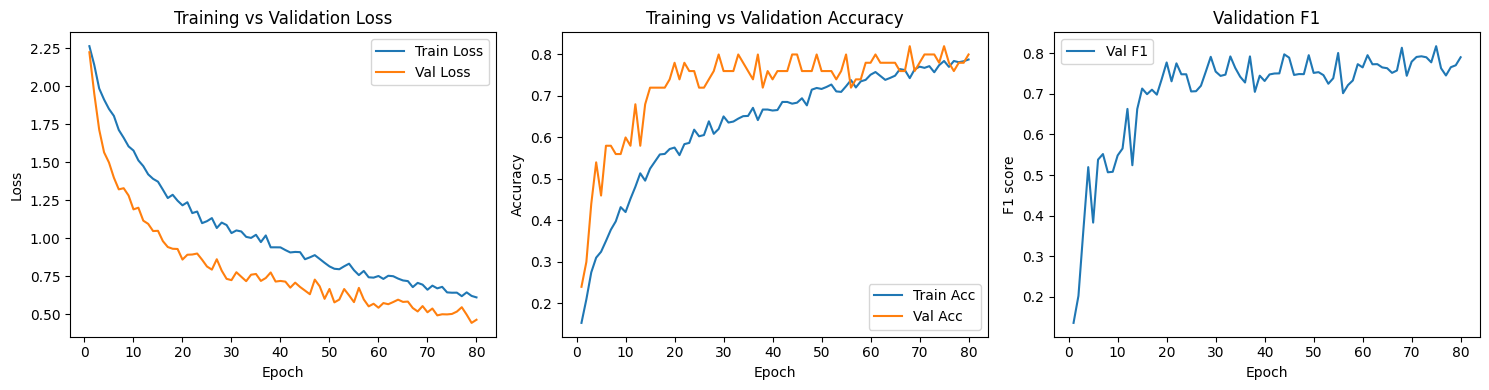

Test Accuracy: 0.9200
Test F1 (macro): 0.9196


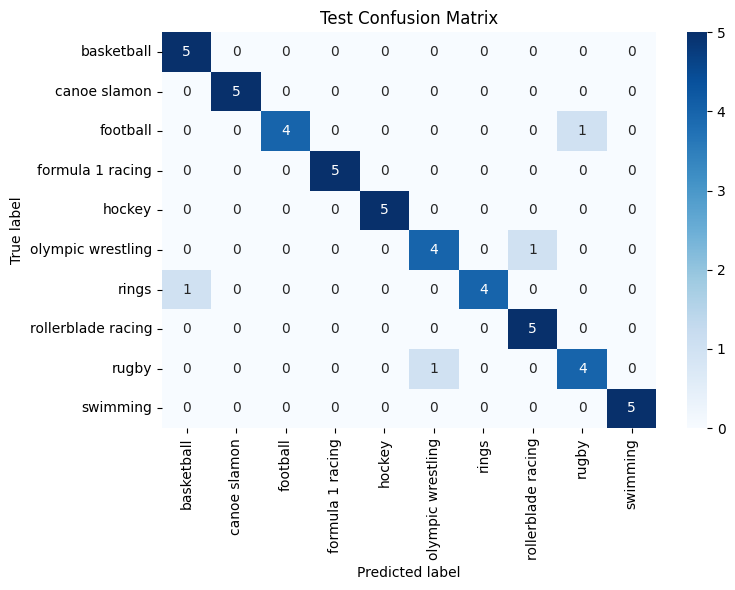

In [ ]:
cfg = Namespace(
    batch_size = 128,
    num_workers = 2,
    max_epochs = 80,
    learning_rate = 0.0001,
)

data_module = ImageDataModule(
    data=data,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
)
data_module.setup()

#model = SimpleCNN(num_classes=data_module.num_classes)
#model = betterCNN(num_classes=data_module.num_classes)
model = CNN(num_classes=data_module.num_classes)

trainer = ImageTrainer(model, data_module, cfg)

trainer.fit()
trainer.test()